# Marginalized Identity and Relationship Satisfaction 

This Python Notebook contains an analysis of "How Couples Meet and Stay Together 2017 (HCMST2017)" as seen in Marginalized Identity and Relationship Satisfaction paper. Data and dataset documentation are available [here](https://data.stanford.edu/hcmst2017).

Author: Yara Kyrychenko

Project collaborators: J. W. Chin, Sharon Lee, Ana Leonard, Anjola Tega, Ralph Spina

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
from sklearn import tree
from scipy.stats.distributions import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_stata('HCMST2017data.dta')

In [3]:
inrel = df[df['partnership_status'] != 'unpartnered, has had past partner']
inrel = inrel[inrel['partnership_status'] != 'never had a partner']

In [4]:
var = ['Race_1','Race_2','Race_3', 'Race_4', 'Race_5','Race_6',
       'interracial_5cat',
       'ppgender',
       'w6_identity',
       'Q23', 'ppincimp', 'ppage',
       'Q4','Q34']
small = inrel[var]

In [5]:
columns = ['white', 'black', 'native', 'asian', 'pacific', 'other',
           'interracial_5cat',
           'gender',
           'w6_identity', 
           'income_disc', 'income', 'age',
           'partner_gender','success']
small.columns = columns

In [6]:
for col in columns:
    small = small[~small[col].isnull()]
    small = small[small[col] != 'Refused']
    small = small[small[col] != '[Partner Name] is Other, please specify]']

In [7]:
small['minority'] = np.where(small['w6_identity'] != 'heterosexual or straight',1,0)

In [8]:
kkcopy = small.copy()
small.drop(['white','black', 'native', 'asian', 'pacific', 'other',
            'interracial_5cat', 'gender','partner_gender'],1)
races = ['white','black', 'native', 'asian', 'pacific', 'other']
for race in races:
    small[race] = np.where(kkcopy[race] == 'Yes', 1, 0)

small['gender'] = np.where(kkcopy['gender'] == 'Male', 1, 0)
small['partner_gender'] = np.where(kkcopy['partner_gender'] == '[Partner Name] is Male', 1, 0)

small['interracial_5cat'] = np.where(kkcopy['interracial_5cat'] == 'yes', 1, 0)

In [9]:
small['earned_more'] = np.where(small['income_disc'] == 'I earned more',1,0)
small['earned_less'] = np.where(small['income_disc'] == '[Partner Name] earned more',1,0)
small['earned_same'] = np.where(small['income_disc'] == 'We earned about the same amount',1,0)
small['partner_does_not_work'] = np.where(small['income_disc'] == '[Partner Name] was not working for pay',1,0)

In [10]:
ycoded = small.copy()
ycoded["income_int"] = ["".join(i.split(" ")[-1][1:].split(",")) for i in ycoded['income']]
ycoded["income_more"] = np.where(ycoded["income_int"] == 'ore', 1, 0)

In [11]:
t = ycoded['income_int'].copy()
k = []
for i in t.index:
    try:
        k.append(int(t[i]))
    except:
        k.append(250000)

ycoded["income_3cat"] = k       
tt = ycoded["income_3cat"].copy()
incomegroups = [50000, 175000]
for i in tt.index:
    if tt[i] < incomegroups[0]:
        tt[i] = "low"
    elif tt[i] < incomegroups[1] and  tt[i] >= incomegroups[0]:
        tt[i] = 'middle'
    else:
        tt[i] = 'high'
        
ycoded['income_3cat'] = tt  
ycoded["income_int"] = k

In [17]:
coded = ycoded.drop(['income_disc','income'],1)
coded_success = coded.copy()
coded_success['success_2cat'] = np.where(coded['success'] == 'Excellent', 1, 0)
one_hot = pd.get_dummies(coded_success, columns = ['income_3cat'])

In [18]:
one_hot.describe()

,white,black,native,asian,pacific,other,interracial_5cat,gender,partner_gender,minority,earned_more,earned_less,earned_same,partner_does_not_work,income_int,income_more,success_2cat,income_3cat_high,income_3cat_low,income_3cat_middle
count,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000
mean,0.844373,0.091524,0.037037,0.039530,0.003561,0.035613,0.159188,0.495370,0.516026,0.155627,0.405627,0.413105,0.120726,0.060541,99499.587251,0.037749,0.599003,0.116453,0.301282,0.582265
std,0.362566,0.288405,0.188886,0.194887,0.059580,0.185355,0.365917,0.500068,0.499832,0.362566,0.491100,0.492479,0.325867,0.238530,66459.269714,0.190623,0.490188,0.320824,0.458897,0.493274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84999.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,124999.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,250000.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Stats

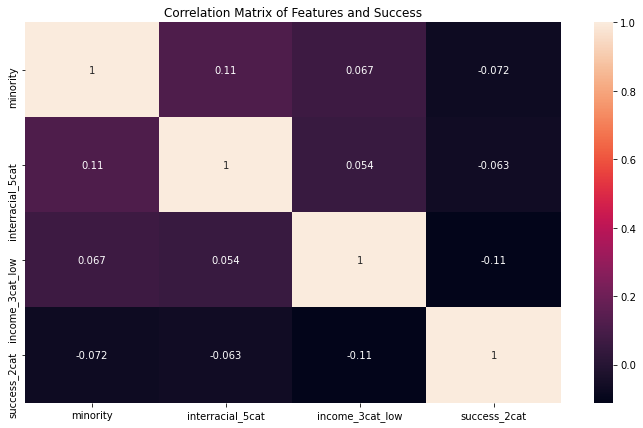

In [19]:
cols_of_interest  = ['minority', 'interracial_5cat', 
                     'income_3cat_low',
                     'success_2cat']
corrMatrix = one_hot[cols_of_interest].corr()

plt.figure(figsize=(12,7))
cm = sns.heatmap(corrMatrix, annot=True)
cm.set(title="Correlation Matrix of Features and Success");

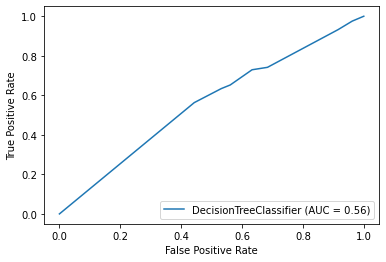

In [20]:
# Decision Tree

X = one_hot[cols_of_interest[:-1]]
y = one_hot['success_2cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

initclf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
initclf.fit(X_train, y_train);
preds = initclf.predict(X_test)

accuracy = accuracy_score(y_true = y_test, y_pred = preds)
plot_roc_curve(estimator = initclf, X = X_test, y = y_test);

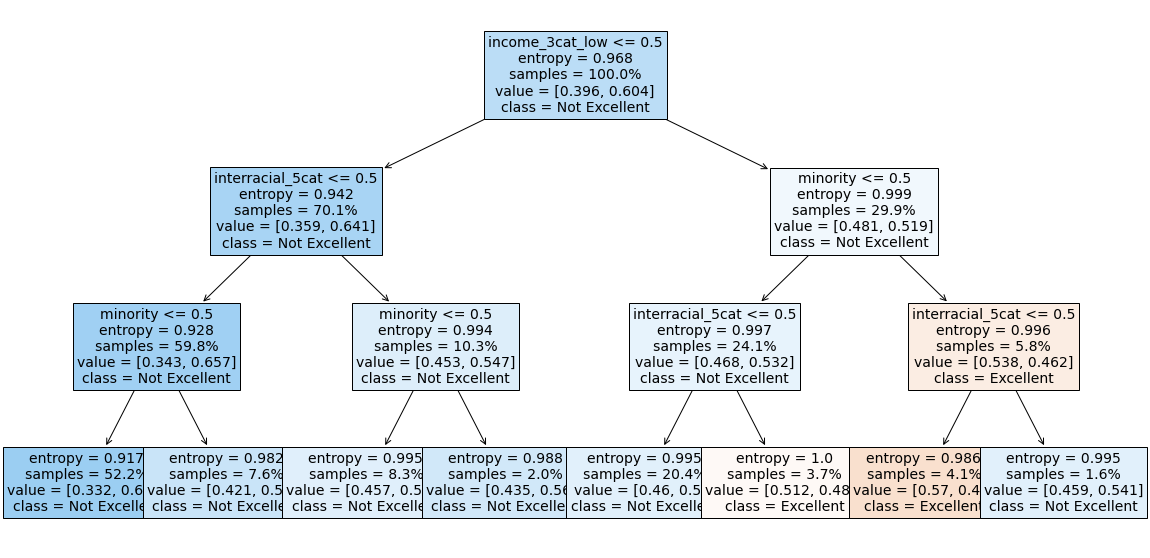

In [21]:
fig = plt.figure(figsize=(20,10))
tree.plot_tree(initclf,
              feature_names=cols_of_interest[:-1],  
            class_names=['Excellent', 'Not Excellent'],
            filled=True, proportion=True, fontsize = 14);
plt.show()

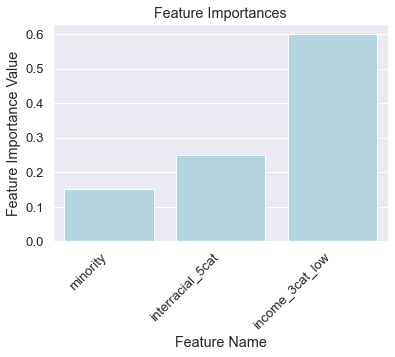

In [22]:

sns.set(font_scale=1.2)

FI = np.array(initclf.feature_importances_)
dfFI = pd.DataFrame({"FI": FI, "featureName": cols_of_interest[:-1]})
sortedFI = dfFI.sort_values(by=["FI"],ascending=True)
ax = sns.barplot(sortedFI["featureName"], sortedFI["FI"], color="lightblue" )
ax.set(ylabel='Feature Importance Value', 
       xlabel='Feature Name', 
       title="Feature Importances")
ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right');

### Model 1

In [48]:
#making interaction terms 
one_hot_inter = one_hot.copy()
one_hot_inter["SMI"] = one_hot["interracial_5cat"]*(1-one_hot["minority"])
one_hot_inter["minority_x_interracial"] = one_hot["minority"]*one_hot["interracial_5cat"]
one_hot_inter["minority_x_income_low"] = one_hot["minority"]*one_hot["income_3cat_low"]
one_hot_inter["interracial_x_income_low"] = one_hot["interracial_5cat"]*one_hot["income_3cat_low"]
one_hot_inter["minority_x_interracial_x_inc_low"] = one_hot["minority"]*one_hot["interracial_5cat"]*one_hot["income_3cat_low"]

In [49]:
# no interactions L1
predictors_inter = ["minority","interracial_5cat","income_3cat_low"]
lm = sm.Logit(one_hot_inter['success_2cat'], sm.add_constant(one_hot_inter[predictors_inter]))
main = lm.fit()

Optimization terminated successfully.
         Current function value: 0.663867
         Iterations 4


In [50]:
def f_test(results):
    A = np.identity(len(results.params))
    A = A[1:,:]
    print(results.f_test(A))

In [51]:
def print_result(results):
    print(f"McFaddens R squared: {results.prsquared},")
    print(f"Chi squared ({int(results.df_model)}): {results.llr}")
    print(f"p value = {round(results.llr_pvalue,5)}\n")
    print("beta:")
    print(results.params)
    print("\nexp(beta):")
    print(np.exp(results.params))
    print("\nconf int:")
    print(np.exp(results.conf_int()))
    print("\n")
    print(results.summary())

In [52]:
print_result(main)

McFaddens R squared: 0.014176591715664322,
Chi squared (3): 53.6143458327806
p value = 0.0

beta:
const               0.644069
minority           -0.328963
interracial_5cat   -0.281772
income_3cat_low    -0.466077
dtype: float64

exp(beta):
const               1.904214
minority            0.719670
interracial_5cat    0.754446
income_3cat_low     0.627459
dtype: float64

conf int:
                         0         1
const             1.720690  2.107312
minority          0.584366  0.886301
interracial_5cat  0.613653  0.927541
income_3cat_low   0.532474  0.739389


                           Logit Regression Results                           
Dep. Variable:           success_2cat   No. Observations:                 2808
Model:                          Logit   Df Residuals:                     2804
Method:                           MLE   Df Model:                            3
Date:                Tue, 03 Aug 2021   Pseudo R-squ.:                 0.01418
Time:                        12:17:

In [53]:
# all interactions L2 but the three way
predictors_inter = ["minority","interracial_5cat","income_3cat_low",
                   "minority_x_interracial", "minority_x_income_low", "interracial_x_income_low"]
lm3 = sm.MNLogit(one_hot_inter['success_2cat'], sm.add_constant(one_hot_inter[predictors_inter]))
no_three_way = lm3.fit()

Optimization terminated successfully.
         Current function value: 0.663271
         Iterations 4


In [54]:
# all interactions L2
predictors_inter = ["minority","interracial_5cat","income_3cat_low",
                   "minority_x_interracial", "minority_x_income_low", "interracial_x_income_low",
                   "minority_x_interracial_x_inc_low"]
lmmaini = sm.Logit(one_hot_inter['success_2cat'], sm.add_constant(one_hot_inter[predictors_inter]))
maini = lmmaini.fit()

Optimization terminated successfully.
         Current function value: 0.663254
         Iterations 4


In [55]:
print_result(maini)

McFaddens R squared: 0.015086922444889517,
Chi squared (7): 57.057118786801766
p value = 0.0

beta:
const                               0.670628
minority                           -0.399207
interracial_5cat                   -0.459319
income_3cat_low                    -0.517552
minority_x_interracial              0.357797
minority_x_income_low              -0.009803
interracial_x_income_low            0.324935
minority_x_interracial_x_inc_low   -0.156721
dtype: float64

exp(beta):
const                               1.955466
minority                            0.670852
interracial_5cat                    0.631714
income_3cat_low                     0.595978
minority_x_interracial              1.430175
minority_x_income_low               0.990245
interracial_x_income_low            1.383941
minority_x_interracial_x_inc_low    0.854942
dtype: float64

conf int:
                                         0         1
const                             1.754559  2.179377
minority             

In [56]:
def likelihood_ratio(llmin, llmax):
    return(2*(llmax-llmin))

def lr_test(L1, L2, df_diff):
    LR = likelihood_ratio(L1,L2)
    p = chi2.sf(LR, df_diff)
    print(f'chi sqrd ({int(df_diff)}):{round(LR,5)}')
    print('p value: %.5f' % p )

In [58]:
lr_test(main.llf,maini.llf,4)

chi sqrd (4):3.44277
p value: 0.48663


#### Adding income disparity to model 1

In [59]:
one_hot_inter["minority_x_earned_same"] = one_hot["minority"]*one_hot["interracial_5cat"]
one_hot_inter["earned_same_x_income_low"] = one_hot["earned_same"]*one_hot["income_3cat_low"]
one_hot_inter["interracial_x_earned_same"] = one_hot["interracial_5cat"]*one_hot["earned_same"]
#one_hot_inter["minority_x_interracial_x_inc_low"] = one_hot["minority"]*one_hot["interracial_5cat"]*one_hot["income_3cat_low"]

In [60]:
# no interactions L1
predictors_inter = ["minority","interracial_5cat","income_3cat_low","earned_same"]
lm = sm.Logit(one_hot_inter['success_2cat'], sm.add_constant(one_hot_inter[predictors_inter]))
disparity = lm.fit()

Optimization terminated successfully.
         Current function value: 0.662940
         Iterations 4


In [61]:
# earned not same no interactions 
predictors_inter = ["minority","interracial_5cat","income_3cat_low","earned_same",
                   "minority_x_earned_same","interracial_x_earned_same",'earned_same_x_income_low']
lm = sm.MNLogit(one_hot_inter['success_2cat'], sm.add_constant(one_hot_inter[predictors_inter]))
nodisparity = lm.fit()

Optimization terminated successfully.
         Current function value: 0.662588
         Iterations 5


### Post-hoc Analysis

##### Gender and Income Disparity

In [62]:
one_hot["male_earned_less"] = (one_hot["gender"])*(one_hot["earned_less"])
one_hot["female_earned_more"] = (1-one_hot["gender"])*one_hot["earned_more"]

In [63]:
predictors2 = ["gender","earned_less"]
lm = sm.Logit(one_hot['success_2cat'], sm.add_constant(one_hot[predictors2]))
gender = lm.fit();

Optimization terminated successfully.
         Current function value: 0.672324
         Iterations 4


In [64]:
predictors2 = ["gender","earned_less","male_earned_less",]
lm = sm.Logit(one_hot['success_2cat'], sm.add_constant(one_hot[predictors2]))
genderi = lm.fit(); 

Optimization terminated successfully.
         Current function value: 0.671518
         Iterations 4


In [65]:
print_result(gender)

McFaddens R squared: 0.0016178416157848208,
Chi squared (2): 6.118503066961239
p value = 0.04692

beta:
const          0.291612
gender         0.198875
earned_less    0.029252
dtype: float64

exp(beta):
const          1.338583
gender         1.220029
earned_less    1.029684
dtype: float64

conf int:
                    0         1
const        1.161002  1.543326
gender       1.038067  1.433888
earned_less  0.874088  1.212978


                           Logit Regression Results                           
Dep. Variable:           success_2cat   No. Observations:                 2808
Model:                          Logit   Df Residuals:                     2805
Method:                           MLE   Df Model:                            2
Date:                Tue, 03 Aug 2021   Pseudo R-squ.:                0.001618
Time:                        12:21:27   Log-Likelihood:                -1887.9
converged:                       True   LL-Null:                       -1890.9
Covariance Type:

In [66]:
print_result(genderi)

McFaddens R squared: 0.0028147719390182457,
Chi squared (3): 10.645164875008959
p value = 0.01381

beta:
const               0.204794
gender              0.336337
earned_less         0.178604
male_earned_less   -0.359390
dtype: float64

exp(beta):
const               1.227273
gender              1.399810
earned_less         1.195547
male_earned_less    0.698102
dtype: float64

conf int:
                         0         1
const             1.043198  1.443828
gender            1.140447  1.718158
earned_less       0.965592  1.480264
male_earned_less  0.501683  0.971422


                           Logit Regression Results                           
Dep. Variable:           success_2cat   No. Observations:                 2808
Model:                          Logit   Df Residuals:                     2804
Method:                           MLE   Df Model:                            3
Date:                Tue, 03 Aug 2021   Pseudo R-squ.:                0.002815
Time:                       

In [68]:
lr_test(gender.llf, genderi.llf, 1)

chi sqrd (1):4.52666
p value: 0.03337


###### not a part of the article but you can try doing that: 

In [1522]:
predictors2 = ["gender","earned_same", "earned_more", "partner_gender"]
lm = sm.Logit(one_hot['success_2cat'], sm.add_constant(one_hot[predictors2]))
result = lm.fit();

print(result.summary())
#print(result.summary2()) 

Optimization terminated successfully.
         Current function value: 0.670067
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           success_2cat   No. Observations:                 2808
Model:                          Logit   Df Residuals:                     2803
Method:                           MLE   Df Model:                            4
Date:                Thu, 24 Jun 2021   Pseudo R-squ.:                0.004971
Time:                        00:27:59   Log-Likelihood:                -1881.5
converged:                       True   LL-Null:                       -1890.9
Covariance Type:            nonrobust   LLR p-value:                 0.0008607
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6485      0.146      4.445      0.000       0.363       0.934
gender           

##### A Race Interracial Model

In [69]:
one_hot["black_interracial"] = one_hot["black"]*one_hot["interracial_5cat"]

In [70]:
predictors2 = ["interracial_5cat", "black"]
lmblack = sm.Logit(one_hot['success_2cat'], sm.add_constant(one_hot[predictors2]))
black = lmblack.fit();

Optimization terminated successfully.
         Current function value: 0.663993
         Iterations 4


In [71]:
f_test(black)

<F test: F=array([[25.6539764]]), p=9.105225525355942e-12, df_denom=2.80e+03, df_num=2>


In [72]:
print_result(black)

McFaddens R squared: 0.01399010082938923,
Chi squared (2): 52.90905734934586
p value = 0.0

beta:
const               0.524781
interracial_5cat   -0.258286
black              -0.863412
dtype: float64

exp(beta):
const               1.690088
interracial_5cat    0.772375
black               0.421721
dtype: float64

conf int:
                         0         1
const             1.551099  1.841532
interracial_5cat  0.627749  0.950319
black             0.323648  0.549512


                           Logit Regression Results                           
Dep. Variable:           success_2cat   No. Observations:                 2808
Model:                          Logit   Df Residuals:                     2805
Method:                           MLE   Df Model:                            2
Date:                Tue, 03 Aug 2021   Pseudo R-squ.:                 0.01399
Time:                        12:22:46   Log-Likelihood:                -1864.5
converged:                       True   LL-Null:   

In [73]:
predictors2 = ["interracial_5cat", "black", "black_interracial"]
lmblacki = sm.Logit(one_hot['success_2cat'], sm.add_constant(one_hot[predictors2]))
blacki = lmblacki.fit();

Optimization terminated successfully.
         Current function value: 0.662919
         Iterations 4


In [74]:
print_result(blacki)

McFaddens R squared: 0.015585053871505994,
Chi squared (3): 58.94099829130073
p value = 0.0

beta:
const                0.540964
interracial_5cat    -0.365653
black               -1.076107
black_interracial    0.727524
dtype: float64

exp(beta):
const                1.717662
interracial_5cat     0.693744
black                0.340920
black_interracial    2.069949
dtype: float64

conf int:
                          0         1
const              1.574626  1.873690
interracial_5cat   0.554904  0.867321
black              0.247999  0.468658
black_interracial  1.160661  3.691595


                           Logit Regression Results                           
Dep. Variable:           success_2cat   No. Observations:                 2808
Model:                          Logit   Df Residuals:                     2804
Method:                           MLE   Df Model:                            3
Date:                Tue, 03 Aug 2021   Pseudo R-squ.:                 0.01559
Time:                

In [75]:
lr_test(black.llf, blacki.llf, 1)

chi sqrd (1):6.03194
p value: 0.01405


##### Interaction plots for the Race model

In [46]:
pd.crosstab(one_hot["interracial_5cat"],[one_hot["black"],one_hot["success_2cat"]])

black               0          1    
success_2cat        0     1    0   1
interracial_5cat                    
0                 804  1381  111  65
1                 167   199   44  37

##### Interaction plots for the Gender model

In [47]:
pd.crosstab(one_hot["gender"],[one_hot["earned_less"],one_hot["success_2cat"]])

earned_less     0         1     
success_2cat    0    1    0    1
gender                          
0             264  324  336  493
1             390  670  136  195

## Exploratory Plots

In [28]:
sns.set(palette = 'summer',font_scale = 1.7)

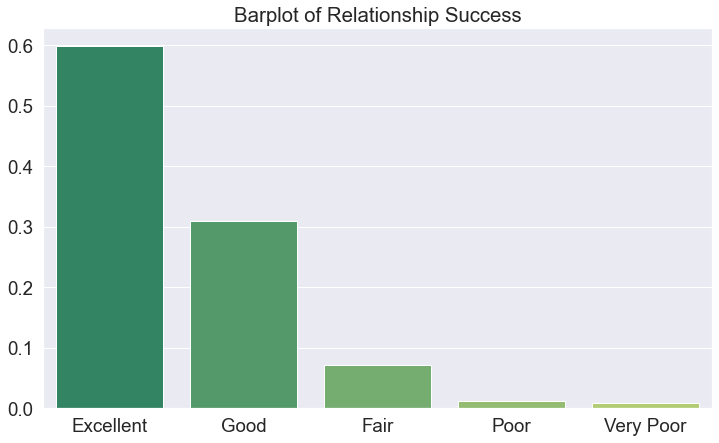

In [32]:
plt.figure(figsize=(12,7))
scs = ['Excellent', 'Good', 'Fair', 'Poor','Very Poor']
stuff = []
for i in scs: 
    stuff.append(sum(np.where(coded['success'] == i, 1, 0))/len(coded))
sns.barplot(scs, stuff);
plt.title("Barplot of Relationship Success");

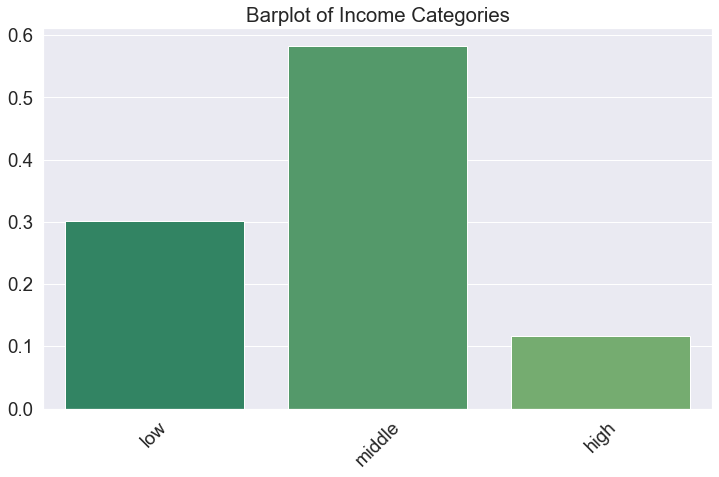

In [34]:
plt.figure(figsize=(12,7))
income_cat = ['low', 'middle', 'high']
stuff = []
for i in income_cat: 
    stuff.append(sum(np.where(coded['income_3cat'] == i, 1, 0))/len(coded))
sns.barplot(income_cat, stuff);
plt.xticks(rotation = 45);
plt.title("Barplot of Income Categories");